In [38]:
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers.experimental import AdamW
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, RandomFlip, RandomTranslation, RandomRotation, RandomZoom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
import tensorflow as tf
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import wandb
from wandb.keras import WandbMetricsLogger

In [39]:
wandb.login()

True

## Set hyperparameters

In [40]:
using_dataset = "data_relabeled_balanced_1x"

train_path = f"facial-affect-data-relabeled/{using_dataset}/train"
test_path = f"facial-affect-data-relabeled/{using_dataset}/test"

image_size = 96
channels = 3
color_mode = "rgb"
validation_split = 0.2
seed = 27

config = {
    "batch_size": 64,
    "epochs": 500,
    "learning_rate": 0.00001,
    "weight_decay": 0.004,
    "early_stop_patience": 10,
    "trainable": False
}

## Run the following block on Kaggle only!

In [41]:
train_path = "/kaggle/input/" + train_path
test_path = "/kaggle/input/" + test_path

## Get class names

In [42]:
classes = next(os.walk(train_path))[1]
print(classes)

['surprise', 'fear', 'neutral', 'sad', 'disgust', 'contempt', 'happy', 'anger']


## Create training, validation and test datasets

In [43]:
train, validation = image_dataset_from_directory(
    directory=train_path,
    validation_split=validation_split,
    subset="both",
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    seed=seed,
    shuffle=True
)

test = image_dataset_from_directory(
    directory=test_path,
    labels="inferred",
    class_names=classes,
    label_mode="int",
    color_mode=color_mode,
    batch_size=config["batch_size"],
    image_size=(image_size, image_size),
    shuffle=False
)

Found 29217 files belonging to 8 classes.
Using 23374 files for training.
Using 5843 files for validation.
Found 7297 files belonging to 8 classes.


## Define on-the-fly augmentations

In [44]:
augmentation = Sequential([
    RandomFlip(mode="horizontal"),
    RandomRotation(factor=0.1),
    RandomZoom(height_factor=0.15),
    RandomTranslation(height_factor=0.15, width_factor=0.15)
])

## Training on ResNet-50 pretrained on ImageNet

In [45]:
wandb.init(config=config, project='resnet-final-model')

optimizer = AdamW(
    learning_rate=config["learning_rate"],
    weight_decay=config["weight_decay"]
)

loss = SparseCategoricalCrossentropy()
metrics = [SparseCategoricalAccuracy()]

inputs = Input(shape=(image_size, image_size, channels))
x = augmentation(inputs)
x = preprocess_input(x)

model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, channels),
    pooling="avg"
)
model.trainable = config["trainable"]

outputs = model(x)

top = Dense(units=2048, activation='relu')(outputs)
top = Dropout(rate = 0.5)(top)
top = Dense(units=512, activation='relu')(top)
top = Dropout(rate = 0.2)(top)
top = Dense(units=len(classes), activation='softmax')(top)

model = Model(inputs=inputs, outputs=top)

early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    verbose=1,
    patience=config["early_stop_patience"],
    restore_best_weights=True
)

callbacks = [
    early_stopping,
    WandbMetricsLogger()
]

In [46]:
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

history = model.fit(train, validation_data=validation, epochs=config["epochs"], callbacks=callbacks)

Epoch 1/500
366/366 [==============================] - 266s 706ms/step - loss: 2.6917 - sparse_categorical_accuracy: 0.1708 - val_loss: 1.9928 - val_sparse_categorical_accuracy: 0.2497
Epoch 2/500
366/366 [==============================] - 257s 702ms/step - loss: 2.2541 - sparse_categorical_accuracy: 0.2069 - val_loss: 1.9091 - val_sparse_categorical_accuracy: 0.2778
Epoch 3/500
366/366 [==============================] - 260s 709ms/step - loss: 2.1083 - sparse_categorical_accuracy: 0.2210 - val_loss: 1.8804 - val_sparse_categorical_accuracy: 0.2920
Epoch 4/500
366/366 [==============================] - 257s 702ms/step - loss: 2.0321 - sparse_categorical_accuracy: 0.2409 - val_loss: 1.8667 - val_sparse_categorical_accuracy: 0.3012
Epoch 5/500
366/366 [==============================] - 257s 700ms/step - loss: 1.9920 - sparse_categorical_accuracy: 0.2441 - val_loss: 1.8555 - val_sparse_categorical_accuracy: 0.3115
Epoch 6/500
366/366 [==============================] - 257s 700ms/step - lo

In [47]:
wandb.finish()

epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch/sparse_categorical_accuracy,▁▂▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
epoch/val_loss,█▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_sparse_categorical_accuracy,▁▃▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████▇████████
epoch/epoch,110
epoch/learning_rate,1e-05
epoch/loss,1.52118
epoch/sparse_categorical_accuracy,0.43767
epoch/val_loss,1.64142


## Plotting training progress

<AxesSubplot:>

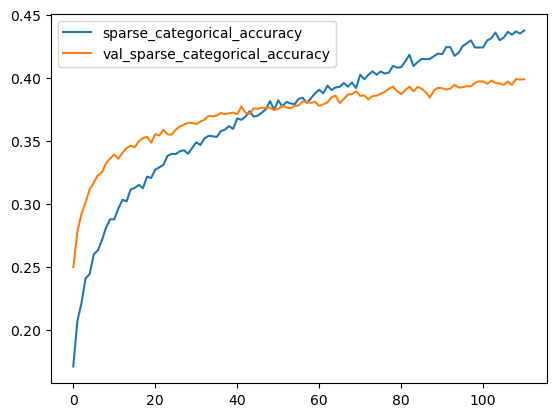

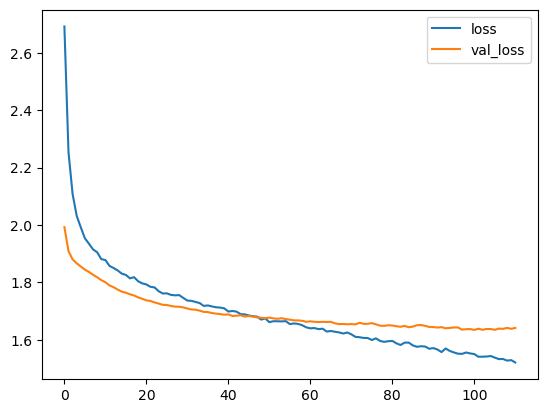

In [48]:
history_df = pd.DataFrame(history.history)

history_df[["sparse_categorical_accuracy", "val_sparse_categorical_accuracy"]].plot()
history_df[["loss", "val_loss"]].plot()

## Predict

In [49]:
y_true_tmp = []
y_pred_tmp = []

for x_test_batch, y_test_batch in test:
    y_true_tmp.append(y_test_batch)
    predictions = model.predict(x_test_batch, verbose=0)
    y_pred_tmp.append(np.argmax(predictions, axis=1))
    
y_true = tf.concat(y_true_tmp, axis=0)
y_pred = tf.concat(y_pred_tmp, axis=0)

## Classification report

In [50]:
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

              precision    recall  f1-score   support

    surprise     0.3512    0.5159    0.4179       913
        fear     0.5345    0.4243    0.4731       912
     neutral     0.3816    0.3235    0.3501       912
         sad     0.4186    0.1184    0.1846       912
     disgust     0.2810    0.1864    0.2241       912
    contempt     0.3666    0.2621    0.3056       912
       happy     0.4422    0.7796    0.5643       912
       anger     0.3391    0.4967    0.4030       912

    accuracy                         0.3884      7297
   macro avg     0.3893    0.3884    0.3654      7297
weighted avg     0.3893    0.3884    0.3654      7297



## Confusion matrix

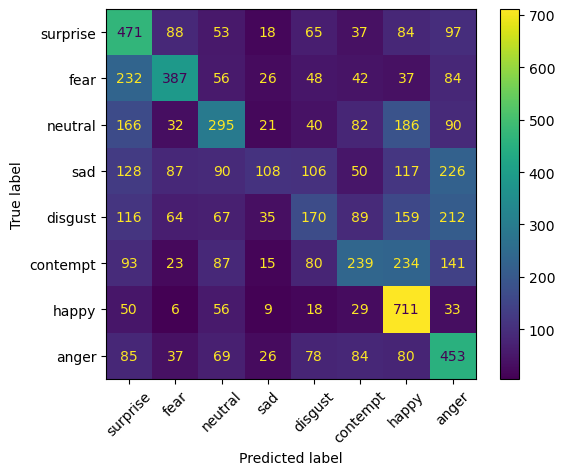

In [51]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=classes, xticks_rotation=45)